In [2]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.cluster import DBSCAN
import string
import unicodedata
# from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy

In [146]:
# loading the dataset
train=pd.read_csv("quora.csv")

In [147]:
#convert each question to a list of string
data = pd.Series(train["question"].tolist()).astype(str)

In [148]:
data = data[:1000]

In [149]:
data.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [150]:
sentences_list = data

## Text Preprocessing

In [151]:
nlp = spacy.load('en_core_web_sm')
stop_list = ['best','different',"won\'t", "couldn\'t", "mustn\'t", "didn\'t", "dtype object"]
for word in stop_list:
    spacy.lang.en.stop_words.STOP_WORDS.add(word)
    nlp.vocab[word].is_stop = True

In [152]:
def normalize(data):
    """Run all the functions for preprocessing in a pipeline"""
    clean_data = re.sub(re.compile('<.*?>'), '', data)
    cleaned_list = [ unicodedata.normalize('NFKD', word.text).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in  nlp(clean_data)]
    cleaned_list = " ".join(cleaned_list)
    cleaned_list = [word.text.rstrip('0123456789').lower() for word in nlp(cleaned_list) if word.pos_  in ['NOUN','PROPN', 'VERB'] and not word.is_digit and not word.is_punct and not word.is_stop ]
    return cleaned_list

In [153]:
# Preprocess the text data
normalized_data = []
for i, batch in data.groupby(np.arange(len(data)) // 10):
    for batch_data in batch:
        normalized_data.append(normalize(batch_data))

In [154]:
# Data after prerocessing
normalized_data 

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'koh', 'noor', 'diamond'],
 ['increase', 'speed', 'internet', 'connection', 'vpn'],
 ['solve'],
 ['dissolve', 'water', 'sugar', 'salt', 'methane', 'carbon', 'oxide'],
 ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rising'],
 ['buy', 'tiago'],
 ['geologist'],
 ['use'],
 ['motorola', 'company', 'hack', 'charter', 'motorolla', 'dcx'],
 ['method', 'find', 'separation', 'slits', 'fresnel', 'biprism'],
 ['read', 'find', 'youtube', 'comments'],
 ['physics', 'learn'],
 ['experience'],
 ['laws',
  'change',
  'status',
  'student',
  'visa',
  'card',
  'compare',
  'immigration',
  'laws',
  'canada'],
 ['trump', 'presidency', 'mean', 'master', 'students', 'f', 'visa'],
 ['manipulation', 'mean'],
 ['girls', 'want', 'friends', 'guy', 'reject'],
 ['quora', 'users', 'posting', 'questions', 'answered', 'google'],
 ['marketing', 'institution', 'banglore'],
 ['rockets', 'look'],
 ['causing'],
 ['quest

In [155]:
# function to form sentences from token
sentence = []
sentences = []


def token_2_sentence(normalized_data):
    """Join the tokens in each list with space to form a sentence"""
    for i in normalized_data:
      sentence = " ".join(i)
      sentences.append(sentence)
      sentence = [] 
    return sentences
    
sentences_list = token_2_sentence(normalized_data)

In [156]:
sentences_list[:10]

['step step guide invest share market india',
 'story kohinoor koh noor diamond',
 'increase speed internet connection vpn',
 'solve',
 'dissolve water sugar salt methane carbon oxide',
 'astrology capricorn sun cap moon cap rising',
 'buy tiago',
 'geologist',
 'use',
 'motorola company hack charter motorolla dcx']

## DBSCAN with DOC2VEC

In [157]:
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [158]:

def tagged_document(normalized_data):
    tagged_corpus = []
    tagged_corpus = [TaggedDocument(words = d, tags=[str(i)]) for i,d in enumerate(normalized_data)]
    return tagged_corpus

In [251]:
tagged_corpus =  tagged_document(normalized_data)

In [259]:

def build_model(tagged_corpus,max_epochs,vec_size, alpha):  
    model = Doc2Vec(size=vec_size, alpha=alpha,min_alpha=0.001, min_count=1,dm =1)
    model.build_vocab(tagged_corpus)

    for epoch in range(max_epochs):
        model.train(tagged_corpus,total_examples=model.corpus_count, epochs=model.iter)
        # decrease the learning rate
        model.alpha -= 0.002
        # fix the learning rate, no decay
        model.min_alpha = model.alpha

        
    model.save("d2v.model")
    print("Model Saved")
    model_name = "d2v.model"
    return model_name


In [260]:
# from gensim.models.doc2vec import Doc2Vec

def load_model(model_name, data):
    corpus_vector = []
    model= Doc2Vec.load(model_name)
    for doc in data:
        corpus_vector.append(model.infer_vector(doc.split()))
    return corpus_vector

In [272]:
max_epochs = 100
vec_size = 100
alpha = 0.001
model_name = build_model(tagged_corpus,max_epochs,vec_size, alpha)

/home/gargi/.local/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/home/gargi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


Model Saved


In [273]:
corpus_vector = load_model("d2v.model",data)  

In [274]:
 corpus_vector = np.array(corpus_vector)

In [305]:
from sklearn.decomposition import PCA

def dbscan(corpus_vector):
    """Function to form dbscan clusters and display them"""
#     eps = 0.005# how close points should be to each other to be considered a part of a cluster 
#     min_samples = 3# the minimum number of points to form a dense region  
#     dbscan = DBSCAN( eps=eps, min_samples=min_samples,metric = "cosine" ) 
#     dbscan_model = dbscan.fit(corpus_vector)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(corpus_vector)
    print(result.shape)
    db = DBSCAN(eps=0.005, min_samples=3)
    dbscan_model = db.fit(result)
    #Forming the clusters

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels1 = dbscan_model.labels_
    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0) # Number of clusters in labels
    print(labels1)
    print(len(labels1))
    print(n_clusters_) # number of clusters
    
    clusters1 = {} # a dictionary for different cluster 
    for c, i in enumerate(labels1):
        if i == -1:
            continue
        elif i in clusters1:
            clusters1[i].append( data[c] )
        else:
            clusters1[i] = [data[c]]

    for c in clusters1: # print the different clusters
        print("Cluster No."+" "+str(c)+" "+str(clusters1[c]))
        print()

In [307]:
dbscan(corpus_vector)

(1000, 2)
[ 0  1 -1 -1  2  3  4 11  5  6  7 -1  8 -1 -1  9 10  8  5 11 12 13 -1  8
 14  8 11 15 16 17 18 13 58 19  8  8  8  8 20  5  8 21 22 13 -1 13  5 62
 23  8  8 24  8 -1 16  8  8 -1 70 25  6 26  8  8 -1  8  5 -1 27 -1 16 28
 29  8 -1 -1 -1 -1 -1 29 -1 30  8 21 31 32  8 29 -1  5 -1 76  6 33  5 34
 35 36 37 -1 11 -1 -1 26  8  1 -1 -1  5 22 -1 38 -1 20 -1 30 39 -1  8 -1
 -1 -1  1 15 -1  6 26 40  8 26 -1 -1  6 14 16  8 15 15  9 67 -1  1 41 15
 -1 42  8 43 28 -1 43 33 16 -1  8  8 -1 15  8 44  5 15 -1 -1 -1 15 -1 -1
 25 -1 -1 -1 41 45 11 46 -1  8 -1 62 15 -1 16 -1 -1  8 17 47 25 29 29 22
 25 25  5 -1 48 -1 49 47 -1 21  8 29 48 30 -1  8 -1 24 -1 -1 50 -1 -1 51
 -1 25 52 -1 30 51 -1 45 -1 -1  3 53 54 44  8 55 -1  3 -1  8 48 74  8 56
 -1  6 -1 70 -1 54 -1 34 -1 14  4 57 14 -1 -1 25 23 27 77 -1 -1  6 -1  5
  8 55 27 -1 -1 -1 -1 -1 -1 -1 25 18  6  6 -1 49  6 -1 25 46 46  8  8  6
  4 19 -1 -1  8 40  5 -1  6 15 58 36 -1 59  5  8 -1 60 46 21 41 26 78 -1
 44  6 57  5 47 64 46 -1 27 -1 -1 -1 22 -

(1000, 2)


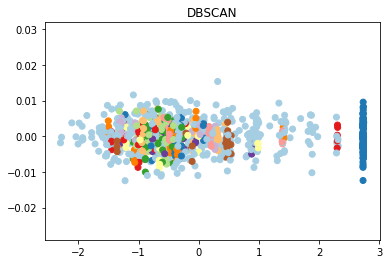

In [304]:
from sklearn.decomposition import PCA

def plot_dbscan(X , eps, min_samples):
    """Function to plot clusters"""
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print(result.shape)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(result)
    y_pred = db.fit_predict(result)
    plt.scatter(result[:,0], result[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    
plot_dbscan( corpus_vector,0.005, 3)